# ISLR- Python Ch6 -- Lab 2: Ridge Regression and the Lasso

- [Load Hitters Dataset](#Load-Hitters-Dataset)
- [6.6.1 Ridge Regression](#6.6.1-Ridge-Regression)
    - [Plot Regression Coeffecients vs Ridge Penalty](#Plot-Regression-Coeffecients-vs-Ridge-Penalty)
    - [Use Validation And Cross Validation to Estimate Test MSE](#Use-Validation-And-Cross-Validation-to-Estimate-Test-MSE )
- [6.6.2 The Lasso](#6.6.2-The-Lasso)
    - [Plot Regression Coeffecients vs Lasso Penalty](#Plot-Regression-Coeffecients-vs-Lasso-Penalty)
    - [Use Cross Validation to Estimate Test MSE](#Use-Cross-Validation-to-Estimate-Test-MSE )

In [3]:
# perform standard imports
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from matplotlib import pyplot as plt
from operator import itemgetter

%matplotlib inline
plt.style.use('ggplot') # emulate R's pretty plotting

# print numpy arrays with precision 4
#np.set_printoptions(precision=4)

## Load Hitters Dataset

In [28]:
# In Lab 1 we explored the hitters dataframe locating rows with missing data and identifying
# categorical variables. See that lab for details...
hitters = pd.read_csv('../../data/Hitters.csv', index_col=0).dropna()

# Create a set of dummy variables for the categoricals
dummies = pd.get_dummies(hitters[['League', 'Division', 'NewLeague']])

# Generate new dataframe with new dummy variables
hitters = hitters.drop(['League', 'Division', 'NewLeague'], axis=1)

# add new dummy variables to hitters
hitters = pd.concat([hitters, dummies[['League_N', 'Division_W', 'NewLeague_N']]],axis=1)

hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,1,0,1
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,1,0,1
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,0,1,0


## 6.6.1 Ridge Regression

In Ridge Regression, we seek to minimize an objective function of the form:

$\sum_{i=1}^{N}{\left(y_i-\beta_0-\sum_{j=1}^{p}{\beta_jx_{i,j}}\right)}^2+\lambda\|\beta_j\|_2^2$. 

** R's GLMNET with $\bf{\alpha=0}$ minimizes the following:** (see https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html and https://core.ac.uk/download/files/153/6287975.pdf)

$\min \left(\frac{1}{2N}\sum_{i=1}^{N}{\left(y_i-\beta_0-\sum_{j=1}^{p}{\beta_jx_{i,j}}\right)}^2+\frac{\lambda}{2}\|\beta_j\|_2^2\right)$

** SKLEARN.RIDGE minimizes:** (see http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression)

$\min \left(\sum_{i=1}^{N}{\left(y_i-\beta_0-\sum_{j=1}^{p}{\beta_jx_{i,j}}\right)}^2+\alpha\|\beta_j\|_2^2\right)$

From the above we can see that **glmnet uses the mean-squared error** and **sklearn minimizes the total squared error**. Also note the glmnet uses standard scaling X-bar(X)/std(X) whereas sklearn uses the l2 norm scaling. We could go through and try to figure out the exact scale differences between the two algorithms but it is not really worth the effort. Instead lets use sklearn to demonstrate that glmnet and sklearn are giving similar results by locating alphas that yield nearly identical results to glmnet.

In [51]:
# Get the predictors and response from hitters 
X = hitters.drop('Salary', axis = 1)
y = hitters.Salary

# list to hold our regression models
regr = []

# alphas
alphas = 10**np.linspace(-4,2,100)

# build models
for index, alph in enumerate(alphas):
    
    # NOTE normalize = True does not standardize the regressors by standard deviation, it divides by
    # the l2 norm of each column.
    model = Ridge(alpha=alph, normalize=True, fit_intercept=True)
    
    regr = np.append(regr, model.fit(X,y))

print('sklearn alpha = ', alphas[89], '\n')
# make a datframe of the results
df = pd.Series(data = np.hstack([regr[89].intercept_, regr[89].coef_]), index = ["Intercept"]+list(X.columns))

print(df,'\n')

print('l2 norm of Betas=', np.sqrt(sum(df.apply(lambda x: x**2).iloc[1:])))

sklearn alpha =  24.7707635599 

Intercept      404.264758
AtBat            0.037839
Hits             0.141609
HmRun            0.536690
Runs             0.236334
RBI              0.245584
Walks            0.296780
Years            1.132897
CAtBat           0.003206
CHits            0.011932
CHmRun           0.089629
CRuns            0.023939
CRBI             0.024716
CWalks           0.025598
PutOuts          0.016928
Assists          0.002681
Errors          -0.021315
League_N         0.101226
Division_W      -6.391921
NewLeague_N      0.319640
dtype: float64 

l2 norm of Betas= 6.54041756347


In [52]:
# show the alpha in sklearn 
print('sklearn alpha =', regr[69].alpha, '\n') 

# make a datframe of the results
df = pd.Series(data = np.hstack([regr[69].intercept_, regr[69].coef_]), 
               index=['Intercept'] + X.columns.tolist())

print(df,'\n')

print('l2 norm of Betas=', np.sqrt(sum(df.apply(lambda x: x**2).iloc[1:])))

sklearn alpha = 1.51991108295 

Intercept      52.027438
AtBat           0.111494
Hits            0.662911
HmRun           1.163824
Runs            0.943734
RBI             0.850159
Walks           1.332308
Years           2.566969
CAtBat          0.010887
CHits           0.047197
CHmRun          0.340725
CRuns           0.094346
CRBI            0.098592
CWalks          0.071532
PutOuts         0.120357
Assists         0.016423
Errors         -0.724175
League_N       13.991874
Division_W    -55.598429
NewLeague_N     8.705727
dtype: float64 

l2 norm of Betas= 58.0965835467


Notice the larger l2 norm when lambda is smaller (i.e. the coeffecient shrinkage is less). We are within 5% of glmnets results. Not sure where difference is at.

## Plot Regression Coeffecients vs Ridge Penalty

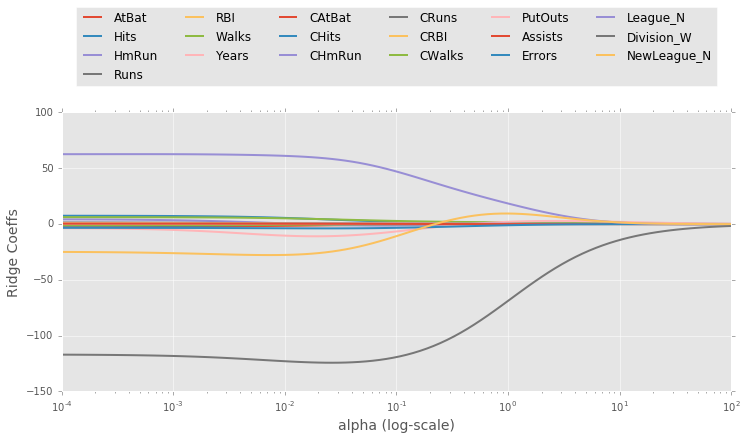

In [54]:
# We can make a plot of each of the ridge regression coeffecients as a function of the shrinkage factor alpha
ridge_coefs = np.empty((len(alphas),X.shape[1]))

# get the ridge coeffecients
for index, model in enumerate(regr):
    ridge_coefs[index] = model.coef_[np.newaxis]
    
# Construct plot    
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(alphas,ridge_coefs, linewidth =2.0);
ax.set_xscale('log')
ax.set_xlabel('alpha (log-scale)', fontsize=14)
ax.set_ylabel('Ridge Coeffs', fontsize=14)
ax.legend(X.columns.tolist(),loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=6);

## Use Validation And Cross Validation to Estimate Test MSE

In [74]:
# MSE- Validation Approach #
############################
np.random.seed(0)
# Split the data into a train and validation set of roughly equal size
train = np.random.choice([True, False], size=len(hitters))

X_train = X[train]
y_train = y[train]
y_test = y[~train]
X_test = X[~train]

# For alpha = 4/(2*len(train) (glmnet_lambda of 4)/2N train the model
model = Ridge(alpha=.009, normalize=True).fit(X_train,y_train)

# Now use the model to predict on the test set
y_predicted = model.predict(X_test)

MSE_validation = np.mean((y_test-y_predicted)**2)
print('MSE alpha=0.009 =', MSE_validation)

# Intercept ONLY Model #
########################
# if we had used the avearge training error (the intercept only model) we get the following MSE
print('MSE Of Intercept Only Model = ', np.mean((np.mean(y[train])-y_test)**2))

# If we use a really large value for alpha then all the coeffecients are ~zero and it is like 
# fitting an intercept only model
model = Ridge(alpha=1e10, normalize=True).fit(X_train,y_train)

# Now use the model to predict on the test set
y_predicted = model.predict(X_test)

MSE_validation = np.mean((y_test-y_predicted)**2)
print('Large Alpha MSE =', MSE_validation)

# Least Squares Model #
#######################
# with alpha =0 we recover least squares model
model = Ridge(alpha=0, normalize=True).fit(X_train,y_train)

# Now use the model to predict on the test set
y_predicted = model.predict(X_test)

MSE_validation = np.mean((y_test-y_predicted)**2)
print('Least Squares MSE =', MSE_validation)

MSE alpha=0.009 = 151903.784214
MSE Of Intercept Only Model =  246681.899436
Large Alpha MSE = 246681.899299
Least Squares MSE = 156763.438385


So we see that fitting a model with small alpha leads to a much lower Test MSE than an intercept only model and a lower Test MSE than the Least Squares Model.

Min Alpha, Min CV =  0.011497569954 114074.045194


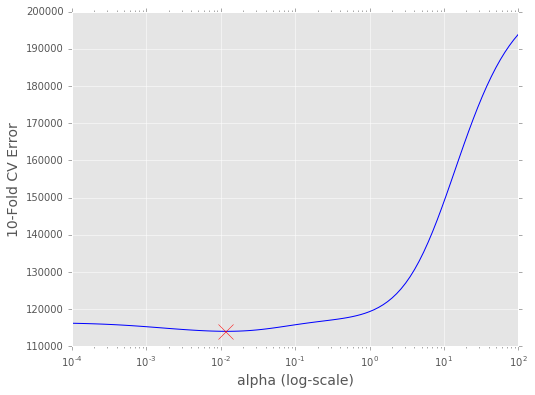

In [77]:
# Cross Validation Approach to Determine Best Alpha #
#####################################################
# scikit learns RidgeCV does not return cross-validation MSEs except for LOOCV case so we will custom write
# the cross validation procedure... In the Lasso Section we present another method that uses sklearn's cross
# validation package

alphas = 10**np.linspace(-4,2, 100)

# construct training and test folds
kf = KFold(len(X), n_folds=10)

cvs = []

for alpha in alphas:
    # For each shrinkage factor compute the models MSE for the 10-folds
    error = []
    
    for train, test in kf:
        # get test/train splits
        X_train = X.values[train]
        y_train = y.values[train]
        X_test = X.values[test]
        y_test = y.values[test]
        
        # build model for each split
        model = Ridge(alpha=alpha, normalize=True).fit(X_train,y_train)
        # compute error for this each response at this alpha for this fold
        error = np.append(error,(model.predict(X_test)-y_test))
        
    # compute mean squared error for this alpha
    cvs = np.append(cvs,np.mean(error**2))

# get the minimum alpha
min_index, min_cvs = min(enumerate(cvs), key=itemgetter(1)) 
print('Min Alpha, Min CV = ', alphas[min_index], min_cvs)

# Plot the CV Errors as a funtion of alpha and plot minimum
fig,ax = plt.subplots(figsize=(8,6))

ax.plot(alphas, cvs, color='b')
ax.plot(alphas[min_index], min_cvs, marker='x', color='r', markersize=15)

ax.set_xscale('log')
ax.set_ylabel('10-Fold CV Error', fontsize=14);
ax.set_xlabel('alpha (log-scale)', fontsize=14);

In [78]:
# Lastly, we can fit the full dataset with this value of alpha
regr = Ridge(alpha=alphas[min_index], normalize=True).fit(X,y)
df = pd.Series(data = np.hstack([regr.intercept_, regr.coef_]), index=['Intercept'] + X.columns.tolist())
df

Intercept      143.906799
AtBat           -1.528135
Hits             5.346385
HmRun            0.414558
Runs            -0.144404
RBI              0.127508
Walks            5.050214
Years          -10.579567
CAtBat          -0.047366
CHits            0.189179
CHmRun           0.694013
CRuns            0.644980
CRBI             0.368395
CWalks          -0.574508
PutOuts          0.278371
Assists          0.278443
Errors          -3.789937
League_N        60.888719
Division_W    -123.206662
NewLeague_N    -27.484108
dtype: float64

It is a little harder to match the labs findings here because we don't have the same train/test splits. Nevertheless, the method is perform CV to locate the minimum alpha and for this alpha fit the model and evaluate on a test set again using CV to estimate the test MSE.

## 6.6.2 The Lasso

Scikit Learn's Lasso method minimizes the following objective function:

$\min \left(\frac{1}{2N}\sum_{i=1}^{N}{\left(y_i-\beta_0-\sum_{j=1}^{p}{\beta_jx_{i,j}}\right)}^2+\alpha\|\beta_j\|_1\right)$

Glmnets cost function with alpha set to 0 yields:

$\min \left(\frac{1}{2N}\sum_{i=1}^{N}{\left(y_i-\beta_0-\sum_{j=1}^{p}{\beta_jx_{i,j}}\right)}^2+\lambda\|\beta_j\|_1\right)$

Again we are not shooting for an exact match since the scaling of glmnet is different than sklearn. We just want to get an idea of how the method works using sklearn and see how close we can get.

In [80]:
# set the values of alpha
grid = 10**np.linspace(-4,2,100)

np.random.seed(0)

# split the data into test and validation sets
train = np.random.choice([True, False], size=len(hitters))

X_train = X[train]
y_train = y[train]
X_test = X[~train]
y_test = y[~train]

coeffecients = np.empty((len(grid),X.shape[1]))

for index, alpha in enumerate(grid):
    # create model with normalize = False
    lasso = Lasso(alpha=alpha, normalize=True, max_iter=10000)
    
    # I made a pipeline so that later if I can hunt down the scaling 
    # problems I can easily include a transform of the predictors
    pipeline = Pipeline([('lasso', lasso)])
    
    # fit scaled training data model
    pipeline.fit(X_train, y_train)
    
    coeffecients[index] = lasso.coef_[np.newaxis]
    

## Plot Regression Coeffecients vs Lasso Penalty

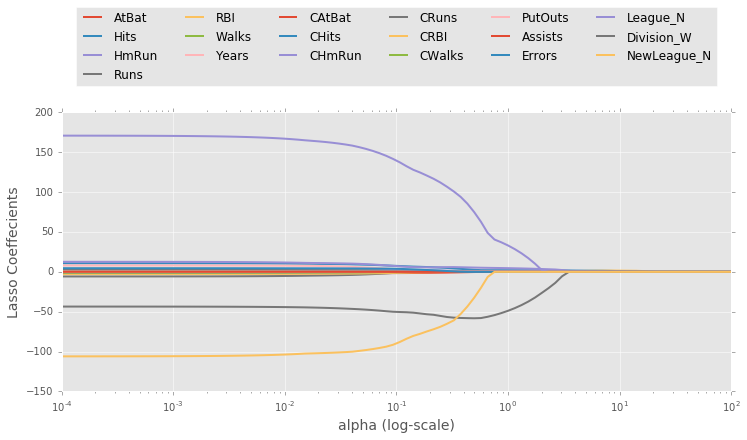

In [81]:
# Make a plot of the coeffecients   
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(grid, coeffecients, linewidth =2.0);

ax.set_xscale('log')
ax.set_xlabel('alpha (log-scale)', fontsize=14)
ax.set_ylabel('Lasso Coeffecients', fontsize=14)
ax.legend(X.columns.tolist(),loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=6);

## Use Cross Validation to Estimate Test MSE

Min Alpha =  0.162975083462


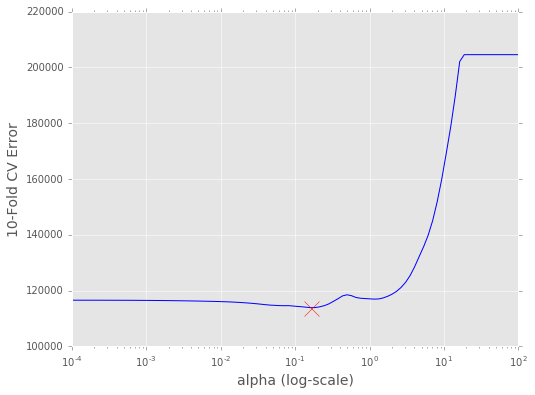

In [83]:
# Cross Validation to determine Optimum Alpha #
###############################################
# We now compute the best alpha, the one that minimize the Cross-Validation error.
# In the ridge regression part of this lab we did this by hand. Here we use sklearns
# cross-validation class.
scores = list()
np.random.seed(0)

# compute cross validation using MSE scoring
for alpha in grid:
    # for each alpha make a new model
    lasso = Lasso(alpha=alpha, normalize=True, max_iter=10000)
    
    # create our pipeline for later potential scaling of predictors
    pipeline = Pipeline([('lasso', lasso)])
    
    # get the cross-val score
    this_scores = -cross_validation.cross_val_score(pipeline, X, y, scoring='mean_squared_error', cv=10)
    scores.append(np.mean(this_scores))

# get the minimum alpha
min_index, min_score = min(enumerate(scores), key=itemgetter(1))
print('Min Alpha = ', grid[min_index])

# Plot the CV Errors as a funtion of alpha and plot minimum
fig,ax = plt.subplots(figsize=(8,6))

ax.plot(grid, scores, color='b')
ax.plot(grid[min_index], min_score, marker='x', color='r', markersize=15)

ax.set_xscale('log')
ax.set_ylabel('10-Fold CV Error', fontsize=14);
ax.set_xlabel('alpha (log-scale)', fontsize=14);

In [87]:
# We could also get the same result using LassoCV...a lot easier
np.random.seed(0)
lasso_cv = LassoCV(alphas=grid, normalize=True, max_iter=10000, cv=10)
lasso_cv.fit(X,y)
lasso_cv.alpha_

0.16297508346206452

In [88]:
np.random.seed(0)

# split the data into test and validation sets
train = np.random.choice([True, False], size=len(hitters))

X_train = X[train]
y_train = y[train]
X_test = X[~train]
y_test = y[~train]

lasso = Lasso(alpha=grid[min_index], normalize=True, max_iter=10000)
lasso.fit(X_train, y_train)
        
mse = np.mean((lasso.predict(X_test)-y_test)**2)
df = pd.Series(data = np.hstack([lasso.intercept_, lasso.coef_]), index=['Intercept'] + X.columns.tolist())
print(df)

Intercept      -34.658086
AtBat           -1.264898
Hits             6.395410
HmRun            5.898740
Runs            -0.000000
RBI             -0.390801
Walks            0.973586
Years            0.000000
CAtBat          -0.034452
CHits           -0.000000
CHmRun           2.008098
CRuns            0.720467
CRBI            -0.239855
CWalks          -0.039428
PutOuts          0.280292
Assists         -0.000000
Errors           2.789974
League_N       124.708168
Division_W     -52.123359
NewLeague_N    -77.683218
dtype: float64


Again these values will depend on the exact train/test split.